# Assignment 2: Depth Estimation From Stereo and Video

In [1]:
import cv2 
import math
import numpy as np
import gco
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1: Noise Removal

In [2]:
def dist(c1, c2):
    dist = np.sum(np.absolute(c1 - c2))/3
    return dist

def add_weight(unary_cost, node, dist_src, dist_sink):
    unary_cost[node] = [dist_src, dist_sink]
    return unary_cost
    
def add_edge(edges, edge_weights, node, next_node, cost_1, cost_2):
    edges.append([node, next_node])
    edge_weights.append(cost_1)
    return edges, edge_weights

def construct_graph(img, m_lambda):
    height, width, colors = img.shape
    
    idxs = np.arange(height*width).reshape(height, width)
    edges = []
    edge_weights = []
    unary_cost = np.zeros([height*width, 2])
    
    for x in range(height):
        for y in range(width):
            c = img[x, y]
            node = idxs[x, y]

            # data term:
            unary_cost = add_weight(unary_cost, node, dist(SOURCE_COLOR,c), dist(SINK_COLOR,c))

            # prior term: start
            if x + 1 < height:
                next_node = idxs[x+1, y] # the right neighbor
                edges, edge_weights = add_edge(edges, edge_weights, node, next_node, m_lambda, m_lambda)
                
            if y + 1 < width:
                next_node = idxs[x, y+1] # the below neighbor
                edges, edge_weights = add_edge(edges, edge_weights, node, next_node, m_lambda, m_lambda)
            # prior term: end
            
    return np.asarray(edges), np.asarray(edge_weights), unary_cost

(573, 769, 3)


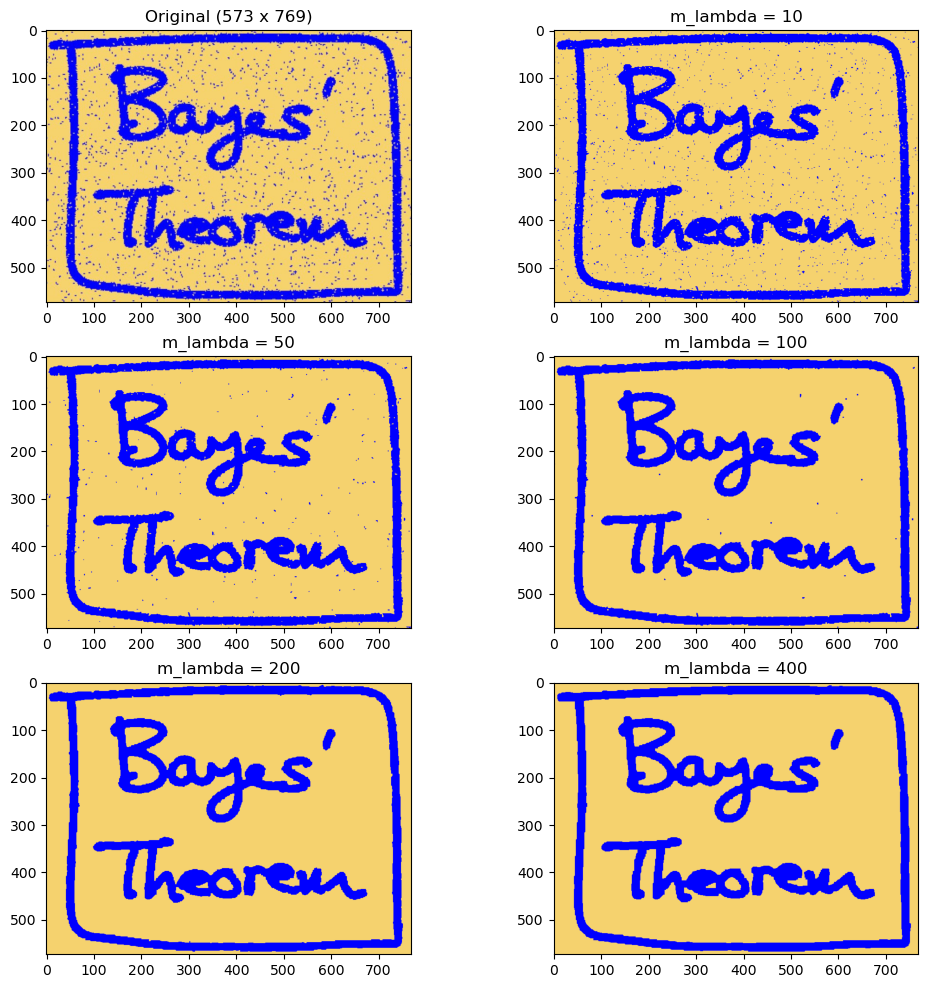

In [3]:
# Some global settings
m_lambdas = [10, 50, 100, 200, 400]; # change this value to change the weight of the smoothness or prior term
SOURCE_COLOR = np.array([0, 0, 255]); # blue = foreground
SINK_COLOR = np.array([245, 210, 110]); # yellow = background

# Read the input image
img = Image.open('media/bayes_in.jpg')
img = np.asarray(img)
print(img.shape)

# Display the original image
_, ax = plt.subplots(3, 2, figsize=(12, 12))
ax[0][0].imshow(np.array(img), cmap='gray')
ax[0][0].title.set_text('Original (%d x %d)' %(np.array(img).shape[0], np.array(img).shape[1]))

for n in range(len(m_lambdas)):
    m_lambda = m_lambdas[n]
    
    # Construct a graph
    edges, edge_weights, unary = construct_graph(img, m_lambda)
    pairwise = (1 - np.eye(2)) * 0.5
    
    # Apply graphcut to get labels
    labels = gco.cut_general_graph(edges, edge_weights, unary, pairwise, n_iter=-1, algorithm="swap")
    labels = labels.reshape(img.shape[:2])
    labels = labels[..., np.newaxis]
    
    # Reconstruct the output image from labels
    img_bg = np.full_like(img, SINK_COLOR)
    img_fg = np.full_like(img, SOURCE_COLOR)
    img_out = labels*img_bg + (1-labels)*img_fg
    
    # Display the image
    i = int((n + 1)/2)
    j = int((n + 1)%2)
    ax[i][j].imshow(img_out)
    ax[i][j].title.set_text('m_lambda = %d' %m_lambda)
    

## Part 1: Noise Removal Observations

It can be viewed that by changing the parameter `m_lambda`, the noise removal result is significantly affected. A smaller value of `m_lambda` leaves more noise in the output image while a larger value of `m_lambda` is able to remove noise more throughtly. 

## Part 2: Depth from Rectified Stereo Images

In [1]:
v

In [2]:
# Read the input image
img_left = Image.open('media/im2.png')
img_left = np.asarray(img_left)
img_right = Image.open('media/im6.png')
img_right = np.asarray(img_right)
print(img_right.shape)

(375, 450, 3)


In [ ]:
max_depths = [10, 50]
n_depth = 50
m_lambdas = [100, 400]

_, ax = plt.subplots(len(max_depths), len(m_lambdas), figsize=(20, 20))

for i in range(len(max_depths)):
    max_depth = max_depths[i]
    print('max_depth = ', max_depth)
    disparity = np.arange(n_depth)/n_depth*max_depth
    # print(disparity)
    
    pairwise = np.zeros((n_depth, n_depth), dtype=int)
    for i_d in range(pairwise.shape[0]):
        for j_d in range(pairwise.shape[1]):
            pairwise[i_d, j_d] = (disparity[i_d] - disparity[j_d])**2
    # print(pairwise.shape)
    
    for j in range(len(m_lambdas)):
        m_lambda = m_lambdas[j]
        print('m_lambda = ', m_lambda)
        
        # Construct a graph
        edges, edge_weights, unary = construct_depth_graph(img_left, img_right, m_lambda, n_depth)

        # Apply graphcut to get labels
        labels = gco.cut_general_graph(edges, edge_weights, unary, pairwise, n_iter=-1, algorithm="swap")
        labels = labels.reshape(img_left.shape[0], img_left.shape[1], -1)
        
        # Display the image
        ax[i][j].imshow(labels, cmap='gray')
        ax[i][j].title.set_text('max_depth = %d, m_lambda = %d' %(max_depth, m_lambda))

max_depth =  10
m_lambda =  100


(50, 50)


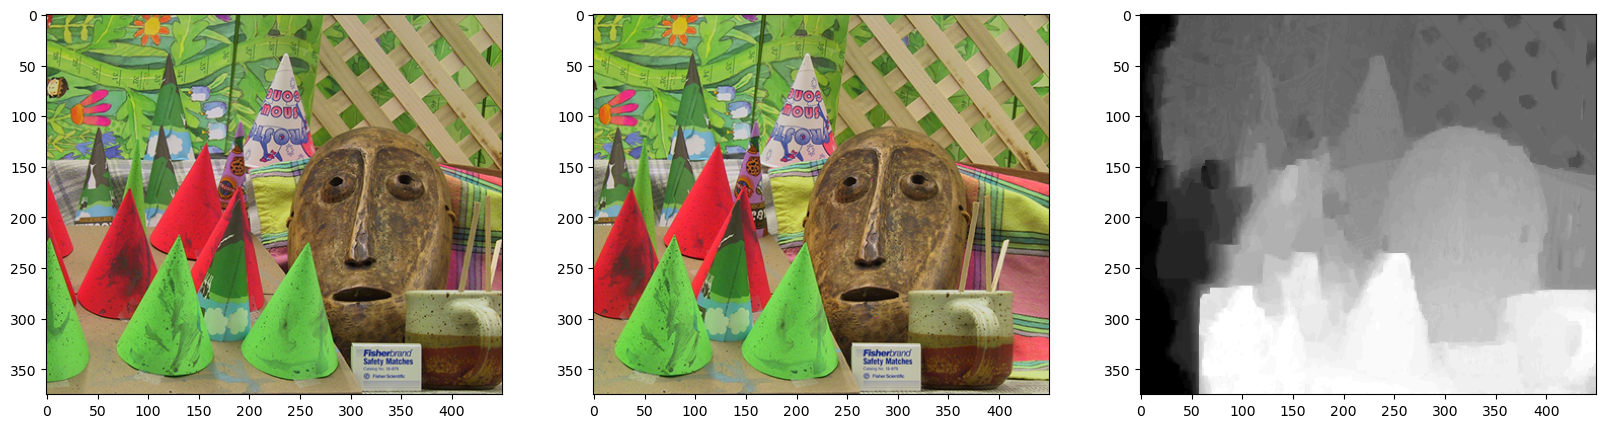

In [4]:
n_depth = 50
m_lambda = 50

disparity = np.arange(n_depth)
# print(disparity)

pairwise = np.zeros((n_depth, n_depth), dtype=int)
for i_d in range(pairwise.shape[0]):
    for j_d in range(pairwise.shape[1]):
        pairwise[i_d, j_d] = abs(disparity[i_d] - disparity[j_d])
print(pairwise.shape)

# Construct a graph
edges, edge_weights, unary = construct_depth_graph(img_left, img_right, m_lambda, n_depth)

# Apply graphcut to get labels
labels = gco.cut_general_graph(edges, edge_weights, unary, pairwise, n_iter=-1, algorithm="swap")
labels = labels.reshape(img_left.shape[0], img_left.shape[1], -1)

# Display the original image
_, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(img_left)
ax[1].imshow(img_right)
ax[2].imshow(labels, cmap='gray')

## Part 2 Observations
By changing the values of `n_depth` and `m_lambda`, the quality of the result varies a lot. From observations, it was found that a larger value of `m_lambda` will result in larger pixel/depth segments, while a smaller value of `m_lambda` will give smaller patches with lots of noise. The `n_depth` controls the number of labels in the graph and the range of the disparity considered for each pixel. Meanwhile, the left side of the left eye image could not find a match in the right eye image due occulsions, causing the depth map in this region unknown. 

## Part 3: Depth from Stereo

In [ ]:
import cv2 
import math
import numpy as np
import gco
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline

def dists(c1, c2):
    dists = np.absolute(c2 - c1)
    dists = np.sum(dists, axis=1)
    return dists/3

def add_weight(unary_cost, node, dists):
    unary_cost[node] = dists
    return unary_cost
    
def add_edge(edges, edge_weights, node, next_node, cost_1, cost_2):
    edges.append([node, next_node])
    edge_weights.append(cost_1)
    return edges, edge_weights

def construct_depth_graph(img_left, img_right, m_lambda, n_labels):
    height, width, colors = img_left.shape
    
    idxs = np.arange(height*width).reshape(height, width)
    edges = []
    edge_weights = []
    unary_cost = np.zeros([height*width, n_labels])
    
    
    for x in range(height):
        for y in range(width):
            c = img_left[x, y]
            node = idxs[x, y]

            # data term:
            start_idx = max(0, y-n_labels)
            img_slice = img_right[x, start_idx:y, :]
            img_slice = np.flip(img_slice, 0) # reverse the slice
            
            disps = dists(c, img_slice)
            full_disps = np.full(n_labels, 255)
            full_disps[:disps.shape[0]] = disps
            
            unary_cost = add_weight(unary_cost, node, full_disps)

            # prior term: start
            if x + 1 < height:
                next_node = idxs[x+1, y] # the right neighbor
                edges, edge_weights = add_edge(edges, edge_weights, node, next_node, m_lambda, m_lambda)
                
            if y + 1 < width:
                next_node = idxs[x, y+1] # the below neighbor
                edges, edge_weights = add_edge(edges, edge_weights, node, next_node, m_lambda, m_lambda)
            # prior term: end
            
    return np.asarray(edges), np.asarray(edge_weights), unary_cost

In [25]:
# Read the input image
img_left = Image.open('media/test00.jpg')
img_left = np.asarray(img_left)
img_right = Image.open('media/test09.jpg')
img_right = np.asarray(img_right)
print(img_right.shape)

# Load the camera matrices
M = np.loadtxt('cam_matrices.txt')
# print(M)

K1 = M[:3]
R1 = M[3:6]
T1 = M[6]

K2 = M[7:10]
R2 = M[10:13]
T2 = M[13]

print(K1, R1, T1)
print(K2, R2, T2)

(540, 960, 3)
[[1.22122708e+03 0.00000000e+00 4.79500000e+02]
 [0.00000000e+00 1.22122708e+03 2.69500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [0. 0. 0.]
[[1.22122708e+03 0.00000000e+00 4.79500000e+02]
 [0.00000000e+00 1.22122708e+03 2.69500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[ 0.99988135  0.01489949  0.0039107 ]
 [-0.01489076  0.99988659 -0.00225327]
 [-0.00394383  0.00219477  0.99998981]] [-9.99097938  0.24517422  0.16508327]
